In [65]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift

**0. Загрузим данные**

In [66]:
cities=pd.read_parquet('cities.parquet')
sales=pd.read_parquet('sales.parquet')
shops=pd.read_parquet('shops.parquet')

**1. Описание датасета**


**Данные по продажам - sales**
* shop_id – уникальный идентификатор магазина
* owner – владелец магазина 
* number_of_counters – количество работающих прилавков/продавцов
* goods_type – тип товара
* total_items_sold – суммарные продажи в этот день в этом магазине в штуках

**Данные по характеристикам магазинов - shops**
* neighborhood – в какой окрестности находится магазин
* city – в каком городе находится магазин 
* year_opened – в каком году открыт магазин
* is_on_the_road – находится ли магазин прямо у дороги
* is_with_the_well – есть ли у магазина колодец 
* is_with_additional_services – есть ли в магазине дополнительные сервисы
* shop_type – тип магазина


**Данные о разбивке городов по локациям - cities**


**2. Обработаем ДатаСет**

Sales

In [67]:
sales

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0
...,...,...,...,...,...,...
5081454,2147-12-31,844,Рейдеры,10,Жидкости для тачки,52.0
5081455,2147-12-31,844,Рейдеры,10,Оружие,82.0
5081456,2147-12-31,844,Рейдеры,10,Броня и одежда,19.0
5081457,2147-12-31,844,Рейдеры,10,Бензак,43071.0


In [68]:
sales.describe()

,shop_id,number_of_counters,total_items_sold
count,5.081459e+06,5.081459e+06,5.081459e+06
mean,4.238431e+02,6.603190e+00,3.666425e+03
std,2.421512e+02,1.859422e+00,8.933075e+03
min,0.000000e+00,1.000000e+00,-5.955000e+03
25%,2.150000e+02,6.000000e+00,4.900000e+01
50%,4.230000e+02,6.000000e+00,2.170000e+02
75%,6.300000e+02,8.000000e+00,1.232000e+03
max,8.440000e+02,2.300000e+01,2.443470e+05


Переведем категориальные признаки в бинарные owner и goods_type

In [69]:
sales['owner'].value_counts()

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [70]:
sales= pd.get_dummies(sales,columns=['owner','goods_type'])

Преобразуем журнал в сводную таблицу

In [71]:
sale1=sales.groupby('shop_id').agg({'total_items_sold':'sum','number_of_counters':'mean'})
sales=sales.drop_duplicates(subset=['shop_id'])
sales=pd.merge(sales,sale1,on='shop_id')
sales.drop('date', axis='columns', inplace=True)

In [72]:
sales

,shop_id,number_of_counters_x,total_items_sold_x,owner_Бомбисты,owner_Воины полураспада,owner_Последователи Апокалипсиса,owner_Рейдеры,owner_Стервятники,goods_type_Бензак,goods_type_Броня и одежда,...,goods_type_Медпрепараты и еда,goods_type_Модификации тачки,goods_type_Оружие,goods_type_Патроны,goods_type_Солярка,goods_type_Съедобный хлам,goods_type_Хлам,goods_type_Ядер-Кола,total_items_sold_y,number_of_counters_y
0,0,4,6.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,11650210.0,4.000000
1,1,5,17.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,10655024.0,5.018981
2,2,4,37.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,10206905.0,3.984816
3,3,4,20.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,25512142.0,4.000000
4,4,10,146.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,28061543.0,9.940336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,6,22.0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,22255020.0,5.973616
841,841,8,0.0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,24243052.0,8.000000
842,842,7,251.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,28750062.0,9.968522
843,843,6,75.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,29445936.0,5.995092


Shops

In [73]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   shop_id                      845 non-null    int32 
 1   neighborhood                 845 non-null    object
 2   city                         788 non-null    object
 3   year_opened                  845 non-null    int32 
 4   is_on_the_road               838 non-null    object
 5   is_with_the_well             785 non-null    object
 6   is_with_additional_services  784 non-null    object
 7   shop_type                    713 non-null    object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


Заполним пустые значения is_on_the_road, is_with_the_well,is_with_additional_services и преобразуем их в категориальные

In [74]:
shops['is_on_the_road'].fillna(0,inplace=True)
shops['is_with_the_well'].fillna(0,inplace=True)
shops['is_with_additional_services'].fillna(0,inplace=True)
shops=pd.get_dummies(shops,columns=['is_on_the_road','is_with_the_well','is_with_additional_services'])

Преобразуем признак neighborhood и shop_type

In [75]:
shops["neighborhood"].value_counts()

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

In [76]:
shops= pd.get_dummies(shops,columns=['neighborhood'])

In [77]:
shops["shop_type"].value_counts()

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [78]:
shops= pd.get_dummies(shops,columns=['shop_type'])

Исправим отрицательные значения года открытия

In [79]:
shops.loc[shops['year_opened']==-1]=shops['year_opened'].median()
shops.describe()

,shop_id,year_opened,is_on_the_road_0,is_on_the_road_да,is_on_the_road_нет,is_with_the_well_0,is_with_the_well_да,is_with_the_well_нет,is_with_additional_services_0,is_with_additional_services_да,...,neighborhood_На отшибе,neighborhood_Промзона,neighborhood_С краю,neighborhood_У воды,neighborhood_У ночлега,neighborhood_У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,...,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000
mean,522.646154,2129.127811,158.953846,159.203550,159.629586,158.955030,159.018935,159.813018,158.956213,159.396450,...,159.084024,159.024852,158.981065,159.036686,159.048521,159.147929,159.391716,159.130178,159.084024,159.004734
std,506.794411,13.328167,560.352448,560.281694,560.160699,560.352113,560.334017,560.108495,560.351778,560.226954,...,560.315577,560.332341,560.344742,560.328989,560.325636,560.297465,560.228298,560.302497,560.315577,560.338039
min,0.000000,2074.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,212.000000,2126.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,426.000000,2132.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,637.000000,2139.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,2132.000000,2143.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000


In [80]:
sales

,shop_id,number_of_counters_x,total_items_sold_x,owner_Бомбисты,owner_Воины полураспада,owner_Последователи Апокалипсиса,owner_Рейдеры,owner_Стервятники,goods_type_Бензак,goods_type_Броня и одежда,...,goods_type_Медпрепараты и еда,goods_type_Модификации тачки,goods_type_Оружие,goods_type_Патроны,goods_type_Солярка,goods_type_Съедобный хлам,goods_type_Хлам,goods_type_Ядер-Кола,total_items_sold_y,number_of_counters_y
0,0,4,6.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,11650210.0,4.000000
1,1,5,17.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,10655024.0,5.018981
2,2,4,37.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,10206905.0,3.984816
3,3,4,20.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,25512142.0,4.000000
4,4,10,146.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,28061543.0,9.940336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,6,22.0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,22255020.0,5.973616
841,841,8,0.0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,24243052.0,8.000000
842,842,7,251.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,28750062.0,9.968522
843,843,6,75.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,29445936.0,5.995092


Объединим shops и sale

In [81]:
shops=pd.merge(sales,shops,on='shop_id',how='left')
shops.fillna(0,inplace=True)
shops

,shop_id,number_of_counters_x,total_items_sold_x,owner_Бомбисты,owner_Воины полураспада,owner_Последователи Апокалипсиса,owner_Рейдеры,owner_Стервятники,goods_type_Бензак,goods_type_Броня и одежда,...,neighborhood_На отшибе,neighborhood_Промзона,neighborhood_С краю,neighborhood_У воды,neighborhood_У ночлега,neighborhood_У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,4,6.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,17.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4,37.0,0,0,0,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,4,20.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,10,146.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,6,22.0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
841,841,8,0.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,842,7,251.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,843,6,75.0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cities

Вставим данные Сities в Shops

In [82]:
cities

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь
5,Пасть,Свистящие Степи
6,Аэропорт,Скалистый Могильник
7,Равнина Маяка,Радиоактивная Пустошь
8,Дизельные Жилы,Свистящие Степи
9,Темница,Радиоактивная Пустошь


In [83]:
shops=pd.merge(shops,cities,on='city',how='left')
shops.drop(['city','total_items_sold_y','number_of_counters_y'], axis='columns', inplace=True)
shops= pd.get_dummies(shops,columns=['location'])
shops.fillna(0,inplace=True)


**3. Обучение модели**

In [84]:
NUM_FEATURE_NAMES=['number_of_counters_x','total_items_sold_x','year_opened']
CAT_FEATURE_NAMES=shops.columns.drop(NUM_FEATURE_NAMES).tolist()

In [85]:
scaler = StandardScaler()
shops[NUM_FEATURE_NAMES] =scaler.fit_transform(shops[NUM_FEATURE_NAMES])

In [86]:
id=shops['shop_id']
shops.drop('shop_id', axis='columns', inplace=True)

Используем для понижения размерности данных метод главных компонент (Principal component analysis или _PCA_)

In [87]:
pca = PCA(random_state=2)
pca.fit(shops)
print(pca.explained_variance_ratio_)

[2.15008418e-01 1.78848038e-01 1.28113707e-01 8.73910336e-02
 5.85038240e-02 4.50222305e-02 4.01320005e-02 3.57886818e-02
 3.30250252e-02 2.92732163e-02 2.26603168e-02 2.21285260e-02
 1.85578213e-02 1.56156196e-02 1.38971623e-02 1.12198028e-02
 9.36352475e-03 6.93615531e-03 5.34803235e-03 4.77338600e-03
 4.33713665e-03 3.01241041e-03 2.72446972e-03 2.46188888e-03
 2.02222982e-03 1.87983625e-03 1.20126874e-03 6.50557389e-04
 9.83849804e-05 5.29487867e-06 4.24029338e-32 1.46239795e-33
 1.46239795e-33 1.46239795e-33 1.46239795e-33 1.46239795e-33
 1.46239795e-33 1.46239795e-33 1.46239795e-33 1.46239795e-33
 1.46239795e-33 1.03641077e-33]


In [88]:
pca.explained_variance_ratio_[:9].sum()

0.8218329587805313

Если мы оставим 9 главных компонент с самой большой объяснённой дисперсией, то мы сохраним почти 82 процента информации.

In [89]:
pca = PCA(n_components=9, random_state=100)
shops = pca.fit_transform(shops)
shops.shape

(845, 9)

*Обучаем модель*

In [90]:
ms = MeanShift()
ms.fit(shops)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
labels.shape

[[-1.31475003e-02 -3.51587838e-01 -2.24355409e-01 -6.51234439e-03
   8.07828994e-03 -1.48557492e-02 -1.34563141e-02 -1.00576384e-02
   3.84893742e-04]
 [-1.85779894e+00  3.44436447e+00  5.19570897e-02 -3.09668006e-01
  -7.19722883e-02  4.67608245e-02 -5.11718299e-02  8.73709517e-02
  -1.05549067e-01]
 [ 2.83125203e+00  8.84050535e-01  1.41731743e+00 -2.68933459e-02
   4.66524323e-02  4.94183746e-02  6.52901520e-02  2.84036736e-02
   5.44108061e-04]
 [ 8.05487732e+00  2.90445338e+00  6.78999016e+00 -1.02600222e+00
   5.97009338e-01  7.13439263e-01  3.81005821e-02  6.17566068e-01
   1.89900588e-02]]
Estimated clusters: 4


(845,)

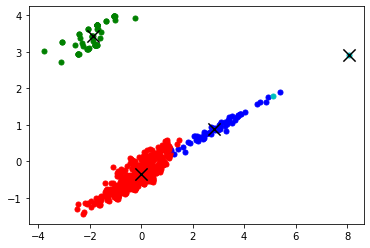

In [91]:
colors = ['r.','g.','b.','c.','k.','y.','.']
for i in range(len(shops)):
    plt.plot(shops[i][0], shops[i][1], colors[labels[i]], markersize = 10)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
   marker = "x",color = 'k', s = 150, linewidths = 5, zorder = 10)
plt.show()

In [92]:
itog=pd.DataFrame({'shop_id':id,'cluster_id': labels})


In [93]:
itog

,shop_id,cluster_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
840,840,1
841,841,1
842,842,1
843,843,1


In [94]:
itog.to_csv('itog.tsv', sep = '\t')
